# NLP 2 : Neural Embeddings, Text Classification, Text Generation


To use statistical classifiers with text, it is first necessary to vectorize the text. In the first practical session we explored the **bag of word** model which is not the most accurate. 

State of the art methods uses language models to vectorize the text before classification.

## Classic word embeddings

- [Word2Vec](https://arxiv.org/abs/1301.3781)
- [Glove](https://nlp.stanford.edu/projects/glove/)


## bleeding edge (only for reference)

- [UMLFIT](https://arxiv.org/abs/1801.06146)
- [ELMO](https://arxiv.org/abs/1802.05365)
- [BERT](https://arxiv.org/abs/1810.04805)


In this second practical session, we mainly explore what can be done with classical word embeddings obtained from `word2vec`



##  Loading data (same as nlp 1)

In [2]:
import glob
from os.path import split as pathsplit

dir_train = "dataset/aclImdb/train/"
dir_test = "dataset/aclImdb/test/"

train_files = glob.glob(dir_train+'pos/*.txt') + glob.glob(dir_train+'neg/*.txt')
test_files = glob.glob(dir_test+'pos/*.txt') + glob.glob(dir_test+'neg/*.txt')


def get_polarity(f):
    """
    Extracts polarity from filename:
    0 is negative (< 5)
    1 is positive (> 5)
    """
    _,name = pathsplit(f)
    if int(name.split('_')[1].split('.')[0]) < 5:
        return 0
    else:
        return 1


def open_one(f):
    
    polarity = get_polarity(f)
    
    with open(f,"r") as review:
        text = " ".join(review.readlines()).strip()
    
    return (text,polarity)

print(open_one(train_files[0]))

train = [open_one(x) for x in train_files] #contains (text,pol) couples
test = [open_one(x) for x in test_files]   #contains (text,pol) couples


('This is a film that the mainstream market will probably never be able to access as it doesn\'t exactly give the viewer easy watching. The story about troubled Spike and his friend Heaton is not exactly a Friday night film yet it has its own unique edge and I found that it was entertaining. There are moments of brilliance given that the film was shot on such a low budget, such as when Spike inhales the aerosol. However I did not really understand the relationship between Spike and Heaton and to be honest it made me spend most of the film trying to work it out. And also I did not like the fact that most of the film is spent with the two friends talking and not really much "action". It is a small film that is complex to watch and that is what makes it appealing.', 1)


## Word2Vec: Quick Recap

**[Word2Vec](https://arxiv.org/abs/1301.3781) is two distinct language models, optimized to quickly learn word vectors**


given a random text: `i'm taking the dog out for a walk`



### (a) Continuous Bag of Word (CBOW)
    -  predicts a word given a context
    
maximizing `p(dog | i'm taking the ___ out for a walk)`
    
### (b) Skip-Gram (SG)               
    -  predicts a context given a word
    
 maximizing `p(i'm taking the out for a walk | dog)`



   

## Step 2: train (or load) a language model (word2vec)

Gensim has one of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) fastest implementation.


### Train:

In [4]:
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

text = [t.split() for t,p in train]

# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=text,
                                size=100, window=5,
                                min_count=5, 
                                sample=0.001, workers=3,
                                sg=0, hs=0, negative=5,
                                cbow_mean=1,
                                iter=5)

2018-11-07 17:33:32,703 : INFO : collecting all words and their counts
2018-11-07 17:33:32,704 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-11-07 17:33:33,452 : INFO : PROGRESS: at sentence #10000, processed 2377615 words, keeping 155725 word types
2018-11-07 17:33:34,197 : INFO : PROGRESS: at sentence #20000, processed 4691609 words, keeping 243773 word types
2018-11-07 17:33:34,579 : INFO : collected 280617 word types from a corpus of 5844680 raw words and 25000 sentences
2018-11-07 17:33:34,580 : INFO : Loading a fresh vocabulary
2018-11-07 17:33:34,975 : INFO : min_count=5 retains 49345 unique words (17% of original 280617, drops 231272)
2018-11-07 17:33:34,976 : INFO : min_count=5 leaves 5517507 word corpus (94% of original 5844680, drops 327173)
2018-11-07 17:33:35,148 : INFO : deleting the raw counts dictionary of 280617 items
2018-11-07 17:33:35,153 : INFO : sample=0.001 downsamples 43 most-common words
2018-11-07 17:33:35,154 : INFO : downsam

### Load pre-trained embeddings:

In [ ]:
# It's for later

#from gensim.test.utils import datapath
#w2v = KeyedVectors.load_word2vec_format(datapath('downloaded_vectors_path'), binary=False)  

In Gensim, embeddings are loaded and can be used via the ["KeyedVectors"](https://radimrehurek.com/gensim/models/keyedvectors.html) class

> Since trained word vectors are independent from the way they were trained (Word2Vec, FastText, WordRank, VarEmbed etc), they can be represented by a standalone structure, as implemented in this module.

>The structure is called “KeyedVectors” and is essentially a mapping between entities and vectors. Each entity is identified by its string id, so this is a mapping between {str => 1D numpy array}.

>The entity typically corresponds to a word (so the mapping maps words to 1D vectors), but for some models, they key can also correspond to a document, a graph node etc. To generalize over different use-cases, this module calls the keys entities. Each entity is always represented by its string id, no matter whether the entity is a word, a document or a graph node.

## STEP 3: Test learnt embeddings

The word embedding space directly encodes similarities between words: the vector coding for the word "great" will be closer to the vector coding for "good" than to the one coding for "bad". Generally, [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is the distance used when considering distance between vectors.

KeyedVectors have a built in [similarity](https://radimrehurek.com/gensim/models /keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.similarity) method to compute the cosine similarity between words

In [ ]:
# is great really closer to good than to bad ?
print("great and good:",w2v.wv.similarity("great","good"))
print("great and bad:",w2v.wv.similarity("great","bad"))

Since cosine distance encodes similarity, neighboring words are supposed to be similar. The [most_similar](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.most_similar) method returns the `topn` words given a query.

In [ ]:
# The query can be as simple as a word, such as "movie"

# Try changing the word
w2v.wv.most_similar("movie",topn=5) # 5 most similar words
#w2v.wv.most_similar("awesome",topn=5)
#w2v.wv.most_similar("actor",topn=5)

But it can be a more complicated query
Word embedding spaces tend to encode much more.

The most famous exemple is: `vec(king) - vec(man) + vec(woman) => vec(queen)`

In [ ]:
# What is awesome - good + bad ?
w2v.wv.most_similar(positive=["awesome","bad"],negative=["good"],topn=3)  

#w2v.wv.most_similar(positive=["actor","woman"],negative=["man"],topn=3) # do the famous exemple works for actor ?


# Try other things like plurals for exemple.


To test learnt "synctactic" and "semantic" similarities, Mikolov et al. introduced a special dataset containing a wide variety of three way similarities.

In [ ]:
out = w2v.wv.accuracy("dataset/questions-words.txt",case_insensitive=True)  #original semantic syntactic dataset.

The review dataset does not perform very well since it hasn't been learnt with a lot of data.


### Try to load a pre-trained word2vec model on a much bigger dataset and redo the experiments.

## STEP 4:  sentiment classification

In the previous practical session, we used a bag of word approach to transform text into vectors.
Here, we propose to try to use word vectors (previously learnt or loaded).

Since we have only word vectors and that sentences are made of multiple words, we need to aggregate them.


### (1) Vectorize reviews using word vectors:

Word aggregation can be done in different ways:

- Sum
- Average
- Min/feature
- Max/feature


In [ ]:
import numpy as np
# We first need to vectorize text:
# First we propose to a sum of them


def vectorize(text,mean=False):
"""
This function should vectorize one review

input: str
output: np.array(float)
"""    
    
    #for word in text:
        # do something
            
    return vec
    

classes = [pol for text,pol in train]
X = [vectorize(text) for text,pol in train]
X_test = [vectorize(text) for text,pol in test]
true = [pol for text,pol in test]

#let's see what a review vector looks like.
print(X[0])

### (2) Train a classifier 
as in the previous practical session, train a logistic regression to do sentiment classification with word vectors

In [ ]:


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scikit Logistic Regression


performance should be worst than with bag of word. Sum/Mean aggregation does not work well on long reviews (especially with many frequent words). This adds a lot of noise.

**(Bonus)** To have a better accuracy, we could try two things:
- Better aggregation methods (weight by tf-idf ?)
- A text vectorizing method such as [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html) or else

## (Bonus) Generate text with a recurrent neural network (Pytorch)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [1]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('dataset/input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)


file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk` 
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [2]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)
    
    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters. 

(tensor([[ 28,  24,  94,  28,  17,  10,  21,  21,  94,  44],
        [ 10,  27,  14,  32,  14,  21,  21,  73,  94,  22],
        [ 96,  55,  17,  14,  27,  14,  94,  10,  27,  29],
        [ 32,  14,  21,  21,  78,  94,  44,  94,  22,  30]]), tensor([[ 24,  94,  28,  17,  10,  21,  21,  94,  44,  94],
        [ 27,  14,  32,  14,  21,  21,  73,  94,  22,  34],
        [ 55,  17,  14,  27,  14,  94,  10,  27,  29,  94],
        [ 14,  21,  21,  78,  94,  44,  94,  22,  30,  28]]))


## The actual RNN model:

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)


=> Complete the `init` function code...


In [3]:
import torch.nn.functional as f

class RNN(nn.Module):
    
    def __init__(self, n_char, hidden_size, output_size, n_layers=1,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()
        
        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)  
        self.embed = ####
        
        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)  
        self.rnn = ####
        
        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)  
        self.predict = ####
    
    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output
    
    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden


## Text generation function

Sample text from the model

In [4]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)
            
    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted



## Training loop for net

In [11]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 5
lr = 0.005
batch_size = 16
chunk_len = 80

####

model = RNN(n_characters, hidden_size, n_characters, n_layers) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad() 
    
    # predict output
    output = model(inp)
    
    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

    #compute gradients and backpropagate
    loss.backward() 
    model_optimizer.step() 

    return loss.data.item() 



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')
       


    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 8s (100 0%) 2.1820]
Whose deang.

QURENAARO: of thow the yous sill manaw y muven en no eneerck yecem thour And hold whan m 

 17s (200 1%) 1.9758]
Whir that he go you this say th with waust in to lith there extorsor and south the thim'd that prether 

 25s (300 1%) 1.9819]
Why uned in that in him dient--
What sou to to mare's not the go grainas wing the pare he why,
And wem 

 33s (400 2%) 1.7471]
Whey to men shee assared at the bouse is sook as at.

MORD:
Come a nen hen soale what able spectten, I 

 41s (500 2%) 1.8626]
Whit you be said,
Alling head. Warrisient not of heors not do and purcle, be ding him this lord lake t 

 50s (600 3%) 1.8683]
Which we preather vere as and stort
I wastay be staince; and the have more is; at brie strest I us the 



KeyboardInterrupt: 

## Visualize loss 

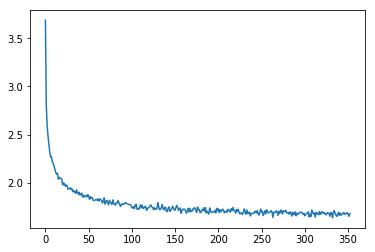

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [12]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1))

TARD I Colk find air widl,
Give well self live
The do pass 'blewitre of the cloe tomfise he broy't
to doarred more, my dear.

Swill they will what lister.

PAENALELO:
The a
to he magedixie wave ouf as,
----
Than a had nment! a tonger; mage Shas my forrows his baud
The that as down sour shour him consine hequentles I joy they him,
And the vich in that Hear him gone his did the heaved youride echill ungerith
----
There the ster of for the have the as for or the prees with the man fate the the hear the still a for man the do you senter lord.

BUCKING RICHARD III:
This starter the my will with the for are of the c
----
That in shall the good where the still the to the make have the stain the day the still the stain the reather that the stain the and the stries in the stand the have of that the heart of the have the co
----
The stand the stand the have the stand the stand the stand the stand the stand the have the stand the stand the have the stand the have the conself the stand the stand t

### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings)
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster
